In [1]:
import json
import os

%load_ext dotenv
%dotenv

# f = open("authPaper.json")
# auth = json.load(f)

In [6]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
# BASE_URL = "https://paper-api.alpaca.markets"
# API_KEY = auth['ID']
# SECRET_KEY = auth['Secret']

In [3]:
api = tradeapi.REST(key_id= os.getenv('API_KEY'), secret_key=os.getenv('SECRET_KEY'), base_url=os.getenv('APCA_API_BASE_URL'), api_version='v2')

In [11]:
import talib as tb

In [48]:
df_apple = api.get_bars("AAPL", TimeFrame.Day, "2020-01-01", "2022-01-08", adjustment='raw').df

In [49]:
macd, macdsignal, macdhist = tb.MACD(df_apple['close'], fastperiod=12, slowperiod=26, signalperiod=9)

<AxesSubplot:xlabel='timestamp'>

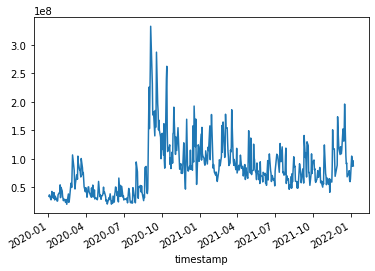

In [59]:
df_apple.volume.plot()

In [71]:
# importing forecasting libraries
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [72]:
arima_model = pm.auto_arima(df_apple['close'], seasonal = False)

# Random Walk (Useless)
A random walk does not help predict the next values only that the variance will increase... lame <br>
This is for predictions involving the closing cost

In [73]:
arima_model

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Forecasting Volume

We can see that volume is dependant on on previous lag with a ar and ma term.

In [74]:
arima_model = pm.auto_arima(df_apple['volume'], seasonal = False)

arima_model

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# Correlation plot

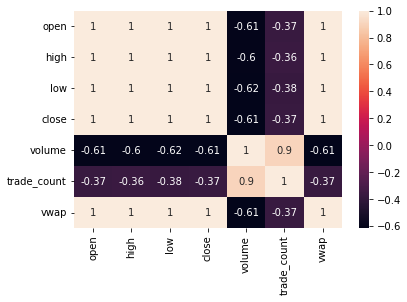

In [75]:
corrMatrix = df_apple.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
# notes, we are able to build an arima model that can predict volume and since there is a negative correlation
# between volume and close price, we could make a prediction using volume and use the forecasted volume as the new data
## AKA Money town Dr. MACD

# I'll work on this another time! 